In [ ]:
from random import random
import numpy as np
import trace_gen as tg # source code at: https://github.com/Effygal/trace-gen
import matplotlib.pyplot as plt
import heapq
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
plt.rcParams['pdf.fonttype'] = 42 
plt.rcParams['ps.fonttype'] = 42 
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['text.usetex']  = False
palette = sns.color_palette("deep")
np.random.seed(777)


In [2]:
def sim_clock(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_clock = [tg.sim_clock(int(_c), trace, raw=True) for _c in c]
    return c, hr_clock

def sim_ran_clock_rp(trace, cnt):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, rp=True, K=cnt) for _c in c]
    return c, hr_ran_clock

def sim_ran_clock_no_rp(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_ran_clock = [tg.sim_ran_clock(int(_c), trace, raw=True, rp=False) for _c in c]
    return c, hr_ran_clock

def sim_sieve(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_sieve = [tg.sim_sieve(int(_c), trace, raw=True) for _c in c]
    return c, hr_sieve

def sim_lru(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_lru = [tg.sim_lru(int(_c), trace, raw=True) for _c in c]
    return c, hr_lru

def sim_fifo(trace):
    M = len(set(trace))
    K = M // 20
    c = np.arange(1, M, K)
    hr_fifo = [tg.sim_fifo(int(_c), trace, raw=True) for _c in c]
    return c, hr_fifo

def gen_from_zipf(M, n, a):
    ranks = np.arange(1, M+1)
    p = ranks**(-a)
    p /= p.sum()
    return p, np.random.choice(M, size=n, p=p)

# def gen_from_iat(lmb, M, n): # buggy
#     lmb = np.asarray(lmb, dtype=float)
#     def sample_ird():
#         lam = np.random.choice(lmb, p=lmb)
#         # return np.random.exponential(1.0 / lam) 
#         return np.random.geometric(lam)
#     h = [(sample_ird(), i) for i in range(M)]
#     heapq.heapify(h)
#     trace = []
#     for _ in range(n):
#         t, addr = heapq.heappop(h)
#         trace.append(addr)
#         heapq.heappush(h, (t + sample_ird(), addr))
#     return np.array(trace, dtype=np.int32)
def gen_from_iad(f, M, n):
    # f(): returns a positive integer IAD sample
    h = [(f(), i) for i in range(M)]
    heapq.heapify(h)
    trace = []
    for _ in range(n):
        t, addr = heapq.heappop(h)
        trace.append(addr)
        heapq.heappush(h, (t + f(), addr))
    return np.array(trace, dtype=np.int32)

In [3]:
lmb, trace1 = gen_from_zipf(10000, 1000000, 0.6)
iads1 = tg.iad(trace1)
iads1 = iads1[iads1 > 0]
f = lambda: int(np.random.choice(iads1))
trace2 = gen_from_iad(f, 10000, 1000000)

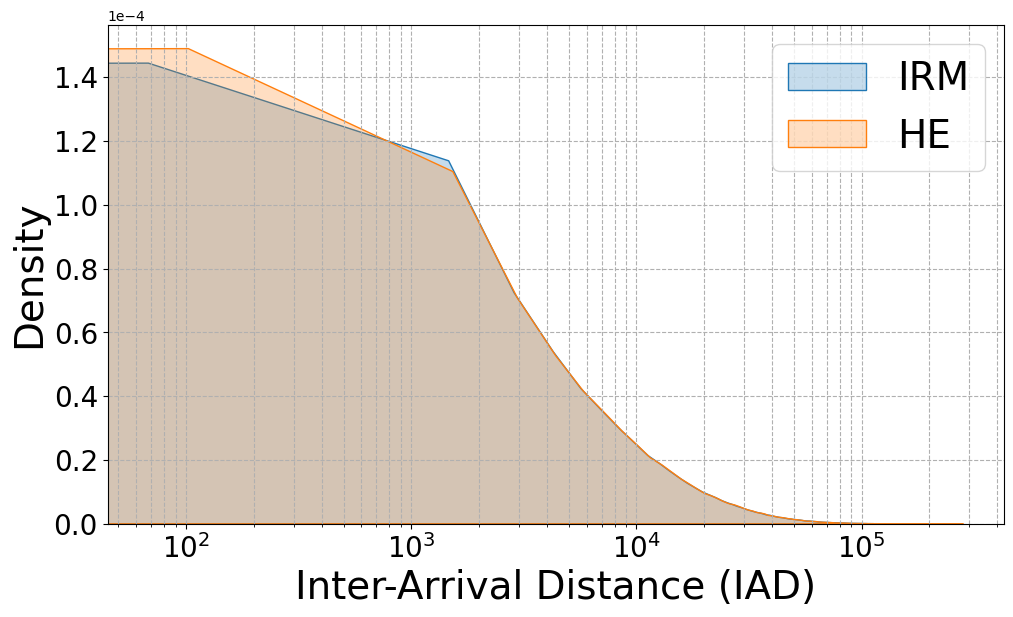

In [4]:
# iads should match
iads2 = tg.iad(trace2)
iads2 = iads2[iads2 > 0]
plt.figure(figsize=(10,6))
sns.kdeplot(iads1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(iads2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.tight_layout()
plt.xscale('log')
plt.xlabel('Inter-Arrival Distance (IAD)', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

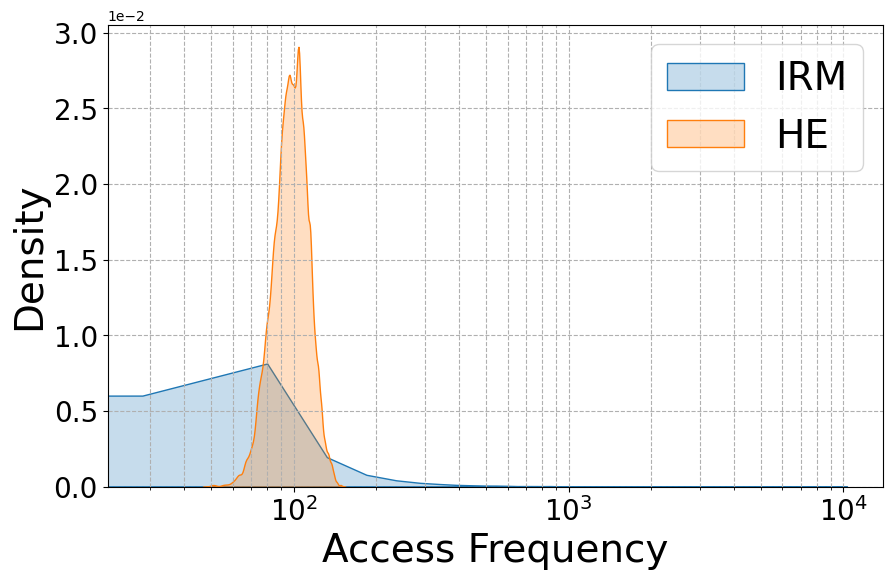

In [18]:
# frequency should not match
u1, c1 = np.unique(trace1, return_counts=True)
u2, c2 = np.unique(trace2, return_counts=True)
plt.figure(figsize=(10,6))
sns.kdeplot(c1, bw_adjust=0.5, label='IRM', fill=True)
sns.kdeplot(c2, bw_adjust=0.5, label='HE', fill=True)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.tick_params(axis='both',  labelsize=20)
plt.xscale('log')
plt.xlabel('Access Frequency', fontsize=28)
plt.ylabel('Density', fontsize=28)
plt.legend(fontsize=28)
plt.grid(True, which="both", ls="--")
plt.show()

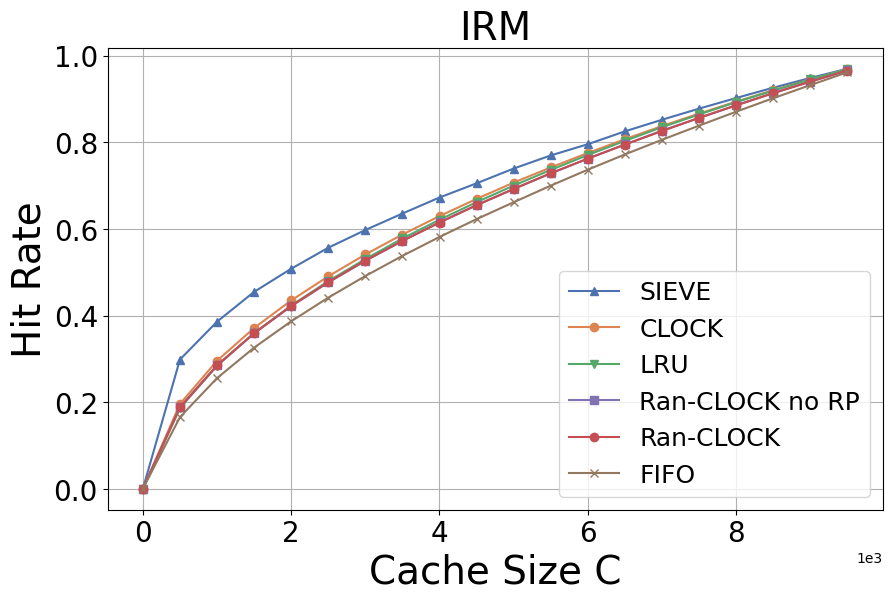

IRM Average Hit Rates:
SIEVE: 0.6714723
CLOCK: 0.6343748499999999
LRU: 0.62836565
Ran-CLOCK no RP: 0.62371145
Ran-CLOCK: 0.62364475
FIFO: 0.5998989499999999


In [36]:
c, hr_ran_clock = sim_ran_clock_rp(trace1)
cn, hr_ran_clock_no_rp = sim_ran_clock_no_rp(trace1)
cc, hr_clock = sim_clock(trace1)
cs, hr_sieve = sim_sieve(trace1)
cl, hr_lru = sim_lru(trace1)
cf, hr_fifo = sim_fifo(trace1)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cs, hr_sieve, color=palette[0], marker='^', label='SIEVE')
plt.plot(cc, hr_clock, color=palette[1], marker='o', label='CLOCK')
plt.plot(cl, hr_lru, color=palette[2], marker='v', label='LRU')
plt.plot(cn, hr_ran_clock_no_rp, color=palette[4], marker='s', label='Ran-CLOCK no RP')
plt.plot(c, hr_ran_clock, color=palette[3], marker='o', label='Ran-CLOCK')
plt.plot(cf, hr_fifo, color=palette[5], marker='x', label='FIFO')
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('IRM', fontsize=28)
plt.grid(True)
plt.show()

avgs = [('SIEVE', np.mean(np.array(hr_sieve))),
        ('CLOCK', np.mean(np.array(hr_clock))),
        ('LRU', np.mean(np.array(hr_lru))),
        ('Ran-CLOCK', np.mean(np.array(hr_ran_clock))),
        ('Ran-CLOCK no RP', np.mean(np.array(hr_ran_clock_no_rp))),
        ('FIFO', np.mean(np.array(hr_fifo)))]
avgs.sort(key=lambda x: x[1], reverse=True)
print("IRM Average Hit Rates:")
for name, avg in avgs:
    print(f"{name}: {avg}")

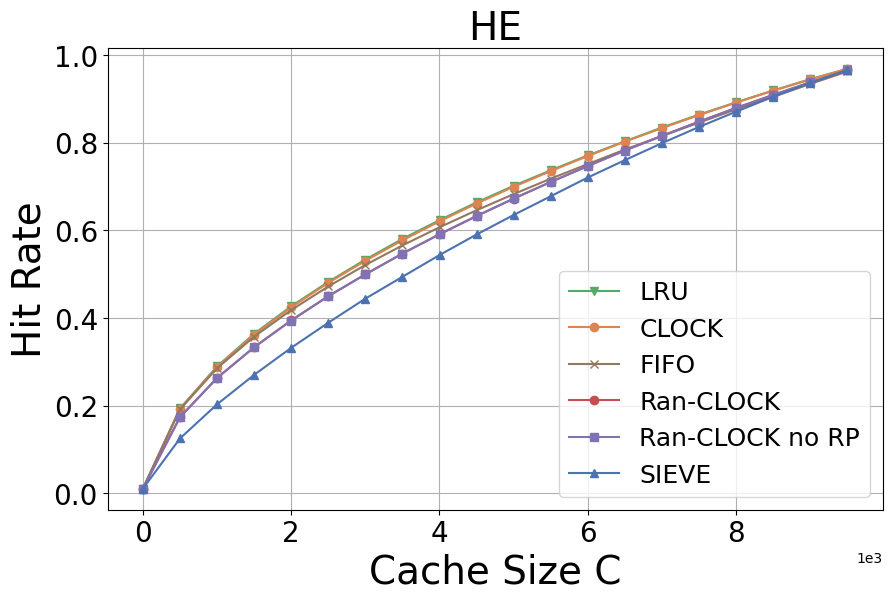

HE Average Hit Rates:
LRU: 0.6301152999999999
CLOCK: 0.628514
FIFO: 0.6173415499999999
Ran-CLOCK: 0.6080223499999999
Ran-CLOCK no RP: 0.6079535500000001
SIEVE: 0.5753432999999999


In [ ]:
c2, hr_ran_clock2 = sim_ran_clock_rp(trace2)
cn2, hr_ran_clock_no_rp2 = sim_ran_clock_no_rp(trace2)
cc2, hr_clock2 = sim_clock(trace2)
cs2, hr_sieve2 = sim_sieve(trace2)
cl2, hr_lru2 = sim_lru(trace2)
cf2, hr_fifo2 = sim_fifo(trace2)

plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(cl2, hr_lru2, color=palette[2], marker='v', label='LRU')
plt.plot(cc2, hr_clock2, color=palette[1], marker='o', label='CLOCK')
plt.plot(cf2, hr_fifo2, color=palette[5], marker='x', label='FIFO')
plt.plot(c2, hr_ran_clock2, color=palette[3], marker='o', label='Ran-CLOCK')
plt.plot(cn2, hr_ran_clock_no_rp2, color=palette[4], marker='s', label='Ran-CLOCK no RP')
plt.plot(cs2, hr_sieve2, color=palette[0], marker='^', label='SIEVE')

plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Hit Rate', fontsize=28)
plt.legend(fontsize=18)
plt.title('HE', fontsize=28)
plt.grid(True)
plt.show()

avgs2 = [('SIEVE', np.mean(np.array(hr_sieve2))),
         ('CLOCK', np.mean(np.array(hr_clock2))),
         ('LRU', np.mean(np.array(hr_lru2))),
         ('Ran-CLOCK', np.mean(np.array(hr_ran_clock2))),
         ('Ran-CLOCK no RP', np.mean(np.array(hr_ran_clock_no_rp2))),
         ('FIFO', np.mean(np.array(hr_fifo2)))]
avgs2.sort(key=lambda x: x[1], reverse=True)
print("HE Average Hit Rates:")
for name, avg in avgs2:
    print(f"{name}: {avg}")

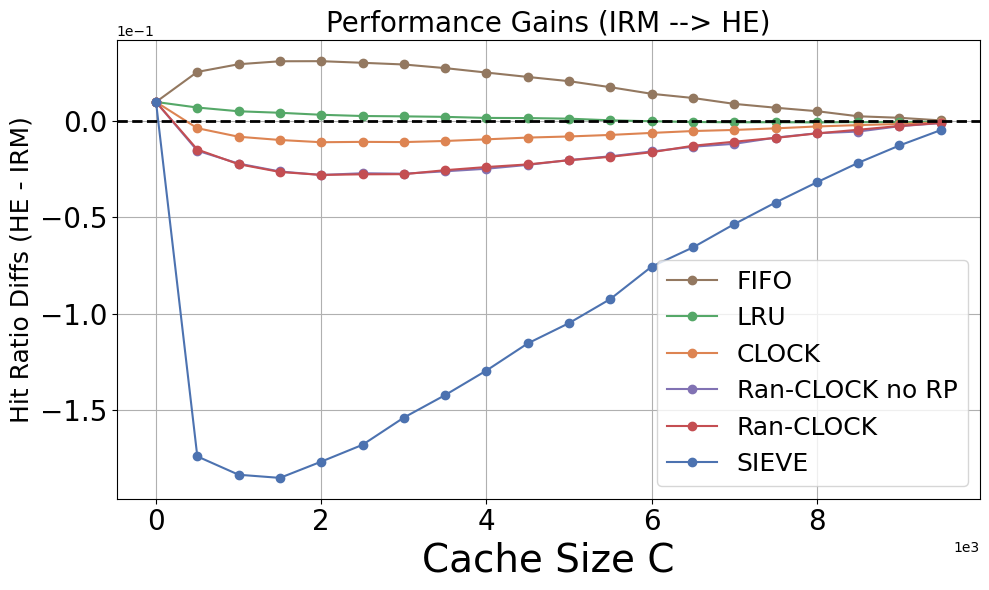

In [ ]:
policies = ["FIFO", "LRU", "CLOCK", "Ran-CLOCK no RP", "Ran-CLOCK", "SIEVE"]
irm_hr = [hr_fifo, hr_lru, hr_clock, hr_ran_clock_no_rp, hr_ran_clock, hr_sieve]
he_hr  = [hr_fifo2, hr_lru2, hr_clock2, hr_ran_clock_no_rp2, hr_ran_clock2, hr_sieve2]
colors = [palette[5], palette[2], palette[1], palette[4], palette[3], palette[0]]

rows = []
for name, irm, he in zip(policies, irm_hr, he_hr):
    irm = np.array(irm)
    he  = np.array(he)
    delta = he - irm
    for C, d in zip(c, delta):
        rows.append({"C": C, "policy": name, "delta_hr": d})

df_delta = pd.DataFrame(rows)
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
for name, color in zip(policies, colors):
    sub = df_delta[df_delta["policy"] == name]
    plt.plot(sub["C"], sub["delta_hr"], marker='o', label=name, color=color)
plt.axhline(0, color='black', linewidth=2, linestyle='--')
plt.xlabel("Cache Size C", fontsize=28)
plt.ylabel("Hit Ratio Diffs (HE - IRM)", fontsize=18)
plt.title("Performance Gains (IRM --> HE)", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
# Data: 
# n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit.
sieve = tg.sieve(4000)
sieve.run(trace1)
rclock = tg.ran_clock(4000)
rclock.run(trace1, rp=True)
rclock2 = tg.ran_clock(4000)
rclock2.run(trace1, rp=False)
clock = tg.clock(4000)
clock.run(trace1)
from trace_gen.lru_wrapper import lru as LRU 
lru = LRU(4000)
lru.run(trace1)
fifo = tg.fifo(4000)
fifo.run(trace1)

print("IRM Data at C=4000")
print("n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit")
print(f"sieve: {sieve.data()}")
print(f"ran-clock: {rclock.data()}")
print(f"ran-clock no rp: {rclock2.data()}")
print(f"clock: {clock.data()}")
print(f"lru: {lru.data()}")
print(f"fifo: {fifo.data()}")

IRM Data at C=4000
n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit
sieve: (1000000, 360430, 6445, 67973, 424403, 632527)
ran-clock: (1000000, 418426, 6445, 245296, 659722, 577876)
ran-clock no rp: (1000000, 418710, 6445, 245333, 660043, 577784)
clock: (1000000, 404514, 6445, 309333, 709847, 593885)
lru: (1000000, 412751, 6445)
fifo: (1000000, 449362, 6445)


In [11]:
sieve = tg.sieve(4000)
sieve.run(trace2)
rclock = tg.ran_clock(4000)
rclock.run(trace2, rp=True)
rclock2 = tg.ran_clock(4000)
rclock2.run(trace2, rp=False)
clock = tg.clock(4000)
clock.run(trace2)
from trace_gen.lru_wrapper import lru as LRU 
lru = LRU(4000)
lru.run(trace2)
fifo = tg.fifo(4000)
fifo.run(trace2)

print("HE Data at C=4000")
print("n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit")
print(f"sieve: {sieve.data()}")
print(f"ran-clock: {rclock.data()}")
print(f"ran-clock no rp: {rclock2.data()}")
print(f"clock: {clock.data()}")
print(f"lru: {lru.data()}")
print(f"fifo: {fifo.data()}")

HE Data at C=4000
n_access; n_miss, n_cachefill, n_recycle, n_examined, sum_abit
sieve: (1000000, 529845, 5544, 207946, 733791, 463507)
ran-clock: (1000000, 445141, 5544, 304457, 745598, 551842)
ran-clock no rp: (1000000, 445879, 5544, 304157, 746036, 550982)
clock: (1000000, 417155, 5544, 367255, 780410, 581247)
lru: (1000000, 414324, 5544)
fifo: (1000000, 429542, 5544)


# Summary
- Under IRM workloads, SIEVE outperforms all other caches; but under HE workloads with the same IAD distribution its performance degrades significantly;
- n_cachefill is the positions in the trace where the 4000th unique block shows up. All caches require 6445 (5544) accesses to fill a capacity-4000 cache under IRM (HE).
- sum_abit counts the accumulated abit counter upon eviction. All clock-based caches have lower sum_abit under HE---sieve decays the most (632572 --> 463507; 26.73%).


# Modeling IRM


In [5]:

# Mean-field solver and closed-form occ distribution for Ran-CLOCK(K)

def _normalize(p):
    p = np.asarray(p, dtype=np.float64)
    total = p.sum()
    if total <= 0:
        raise ValueError
    return p / total

def ran_clock_fixed_point_fast(p, cache_size, K=1, tol=1e-15, max_iter=200):
    p = _normalize(p)
    n = p.size
    target = n - float(cache_size)
    if target <= 0:
        return 1.0, np.zeros_like(p), 0.0

    low, high = 0.0, 1.0
    x_minus1 = None
    for _ in range(max_iter):
        z = 0.5 * (low + high)
        r = p / z
        
        denom = np.where(
            np.abs(r - 1.0) < 1e-12,
            K + 2.0,
            (1.0 - r**(K + 2)) / (1.0 - r)
        )
        x_minus1 = 1.0 / denom
        diff = x_minus1.sum() - target
        if high - low <= tol:
            break
        if diff > 0:
            high = z
        else:
            low = z
    pmiss = np.dot(p, 1.0 / denom) 
    return z, x_minus1, pmiss


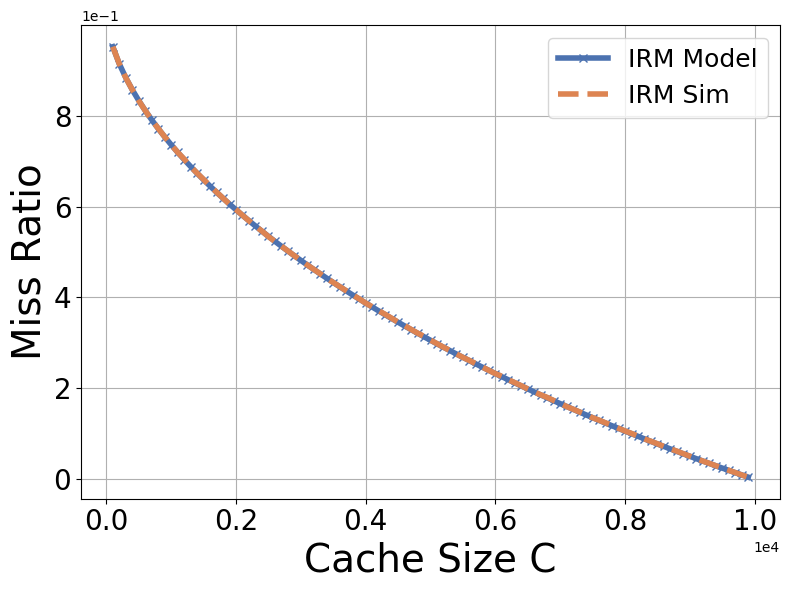

In [6]:
C = np.arange(100, 10000, 100)
mr_irm_model = []
for c in C:
    z, xm1, pmiss = ran_clock_fixed_point_fast(lmb, c, K=5)
    mr_irm_model.append(pmiss)

mr_irm_sim = []
for c in C:
    rclock = tg.ran_clock(c, K=5)
    rclock.run(trace1, rp=True)
    mr_irm_sim.append(1-rclock.hitrate())

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(C, mr_irm_model, label='IRM Model', color=palette[0], marker='x', linewidth=4)
plt.plot(C, mr_irm_sim, label='IRM Sim', color=palette[1], linestyle='--', linewidth=4)
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Miss Ratio', fontsize=28)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

# Modeling Phase-Type

(extremely slow...)

In [7]:
def ranclock_ph_fixed_point_fast(C, K, lmb, rates, tol=1e-15, max_iter=60):
    alpha = np.asarray(lmb, float)
    rates = np.asarray(rates, float)
    if alpha.shape != rates.shape or alpha.ndim != 1:
        raise ValueError
    if not np.isclose(alpha.sum(), 1.0):
        raise ValueError
    d = rates.size
    if not (0 < C < d):
        raise ValueError
    n = d
    mu = rates
    inv_rates = 1.0 / rates
    one = np.ones(d, float)

    def solve_Y(z):
        R_diag = 1.0 / (rates + z)
        Y = [np.zeros(d, float) for _ in range(K + 2)]
        H = [0.0 for _ in range(K + 1)]
        S_K = np.dot(alpha * R_diag, mu)
        if abs(1.0 - S_K) < 1e-12:
            big = np.full(d, 1e10, float)
            for j in range(K + 2):
                Y[j] = big
            return Y
        A_K = S_K / (1.0 - S_K)
        H[K - 1] = 1.0
        H[K] = A_K
        Y[K + 1] = (H[K - 1] + H[K]) * (alpha * R_diag)
        for j in range(K - 1, 0, -1):
            Y[j + 1] = (H[j - 1] * alpha + z * Y[j + 2]) * R_diag
            H[j] = np.dot(Y[j + 1], mu)
        Y[1] = (alpha + z * Y[2]) * R_diag
        H[0] = np.dot(Y[1], mu)
        Y[0] = -z * (Y[1] * (-inv_rates))
        return Y

    def f(z):
        if z <= 0 or z >= 1:
            return 1e10
        Y = solve_Y(z)
        P_minus1 = Y[0].sum()
        P_tot = sum(y.sum() for y in Y)
        if P_tot <= 0:
            return 1e10
        target = (n - C) / n
        return P_minus1 / P_tot - target

    lo = 1e-12
    hi = 1.0 - 1e-12
    f_lo = f(lo)
    f_hi = f(hi)
    if f_lo * f_hi > 0:
        hi = max(1.0, rates.max() * 10.0)
        f_hi = f(hi)
        if f_lo * f_hi > 0:
            raise RuntimeError("failed to bracket root")

    z = None
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        f_mid = f(mid)
        if abs(f_mid) < tol or hi - lo < tol:
            z = mid
            break
        if f_lo * f_mid <= 0:
            hi = mid
            f_hi = f_mid
        else:
            lo = mid
            f_lo = f_mid
    if z is None:
        z = 0.5 * (lo + hi)

    Y_star = solve_Y(z)
    P_tot = sum(y.sum() for y in Y_star)
    c = 1.0 / P_tot
    Y_minus1 = Y_star[0]
    x_minus1_scalar = c * Y_minus1.sum()
    x_minus1 = np.full(n, x_minus1_scalar, float)
    h_minus1 = c * np.dot(Y_minus1, mu)
    pmiss = n * h_minus1
    return z, x_minus1, pmiss

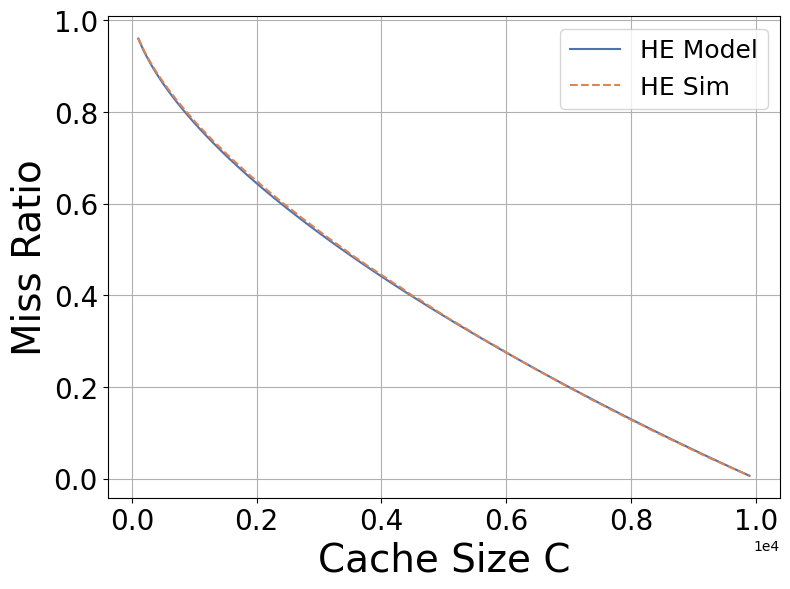

In [ ]:
mr_he_model = []
C = np.arange(100, 10000, 100)
for c in C:
    # mr = ranclock_ph_fixed_point(lmb, lmb, K=1, C=c)
    mr = ranclock_ph_fixed_point_fast(c, K=1, lmb=lmb, rates=lmb)[2]
    mr_he_model.append(mr)
    
mr_he_sim = []
for c in C:
    rclock = tg.ran_clock(c, K=1)
    rclock.run(trace2, rp=True)
    mr_he_sim.append(1-rclock.hitrate())

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(C, mr_he_model, label='HE Model', color=palette[0], linewidth=4)
plt.plot(C, mr_he_sim, label='HE Sim', color=palette[1], linestyle='--', linewidth=4)
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Miss Ratio', fontsize=28)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

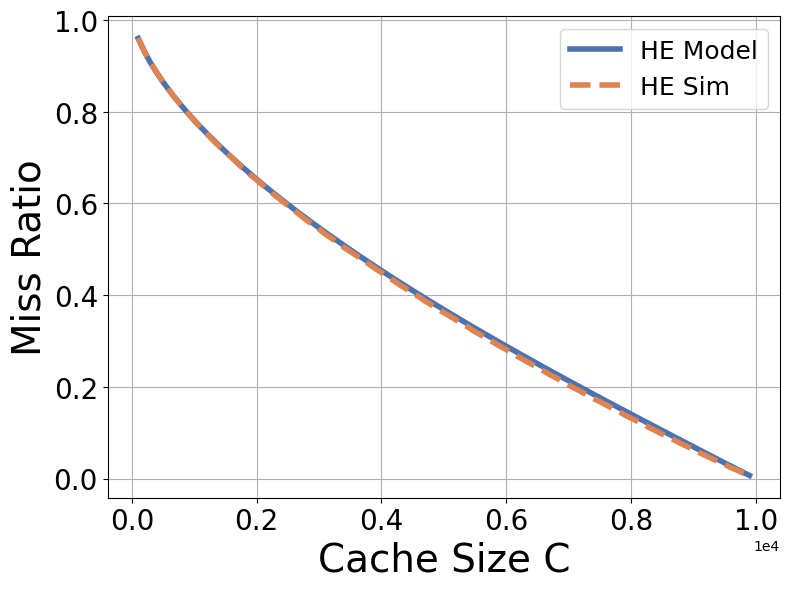

In [10]:
mr_he_model = []
C = np.arange(100, 10000, 100)
for c in C:
    mr = ranclock_ph_fixed_point_fast(c, K=5, lmb=lmb, rates=lmb)[2]
    mr_he_model.append(mr)
    
mr_he_sim = []
for c in C:
    rclock = tg.ran_clock(c, K=5)
    rclock.run(trace2, rp=True)
    mr_he_sim.append(1-rclock.hitrate())

plt.figure(figsize=(8,6))
ax = plt.gca()
ax.tick_params(axis='both', labelsize=20)
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.plot(C, mr_he_model, label='HE Model', color=palette[0], linewidth=4)
plt.plot(C, mr_he_sim, label='HE Sim', color=palette[1], linestyle='--', linewidth=4)
plt.xlabel('Cache Size C', fontsize=28)
plt.ylabel('Miss Ratio', fontsize=28)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
ms = [100, 500, 1000]
ns = [100000, 1000000]
alphas = [0.5, 0.8, 1.1]
ks = [1, 3, 5]
records, errors = [], []

for m in ms:
    for n in ns:
        for a in alphas:
            ranks = np.arange(1, m+1)
            lmb = ranks**(-a) / np.sum(ranks**(-a))
            _, trace1 = gen_from_zipf(m, n, a)  
            iads = tg.iad(trace1)
            iads = iads[iads > 0]
            f = lambda: int(np.random.choice(iads))
            trace2 = gen_from_iad(f, m, n)

            c_vals = np.unique(np.round(np.linspace(m//100+1, m-1, 20)).astype(int))

            for c in c_vals:
                for k in ks:
                    rclock1 = tg.ran_clock(c, k)
                    rclock1.run(trace1, rp=True)
                    mr_irm_sim = 1 - rclock1.hitrate()

                    rclock2 = tg.ran_clock(c, k)
                    rclock2.run(trace2, rp=True)
                    mr_he_sim = 1 - rclock2.hitrate()

                    mr_irm_model = ran_clock_fixed_point_fast(lmb, c, K=k)[2]
                    mr_he_model = ranclock_ph_fixed_point_fast(c, K=k, lmb=lmb, rates=lmb)[2]

                    records.append({
                        "m": m, "n": n, "alpha": a, "C": c, "K": k,
                        "mr_irm_sim": mr_irm_sim,
                        "mr_he_sim": mr_he_sim,
                        "mr_irm_model": mr_irm_model,
                        "mr_he_model": mr_he_model,
                    })

                    errors.append({
                        "m": m, "n": n, "alpha": a, "C": c, "K": k,
                        "error_irm": abs(mr_irm_sim - mr_irm_model),
                        "error_he": abs(mr_he_sim - mr_he_model),
                    })

df_mr = pd.DataFrame(records)
df_err = pd.DataFrame(errors)

In [16]:
print(df_mr[['m','n','alpha','K','C','mr_he_model']]
      .groupby(['m','n'])['mr_he_model']
      .agg(['min','max']))

                   min       max
m    n                          
100  100000   0.002468  0.970493
     1000000  0.002468  0.970493
500  100000   0.000335  0.978798
     1000000  0.000335  0.978798
1000 100000   0.000145  0.979148
     1000000  0.000145  0.979148


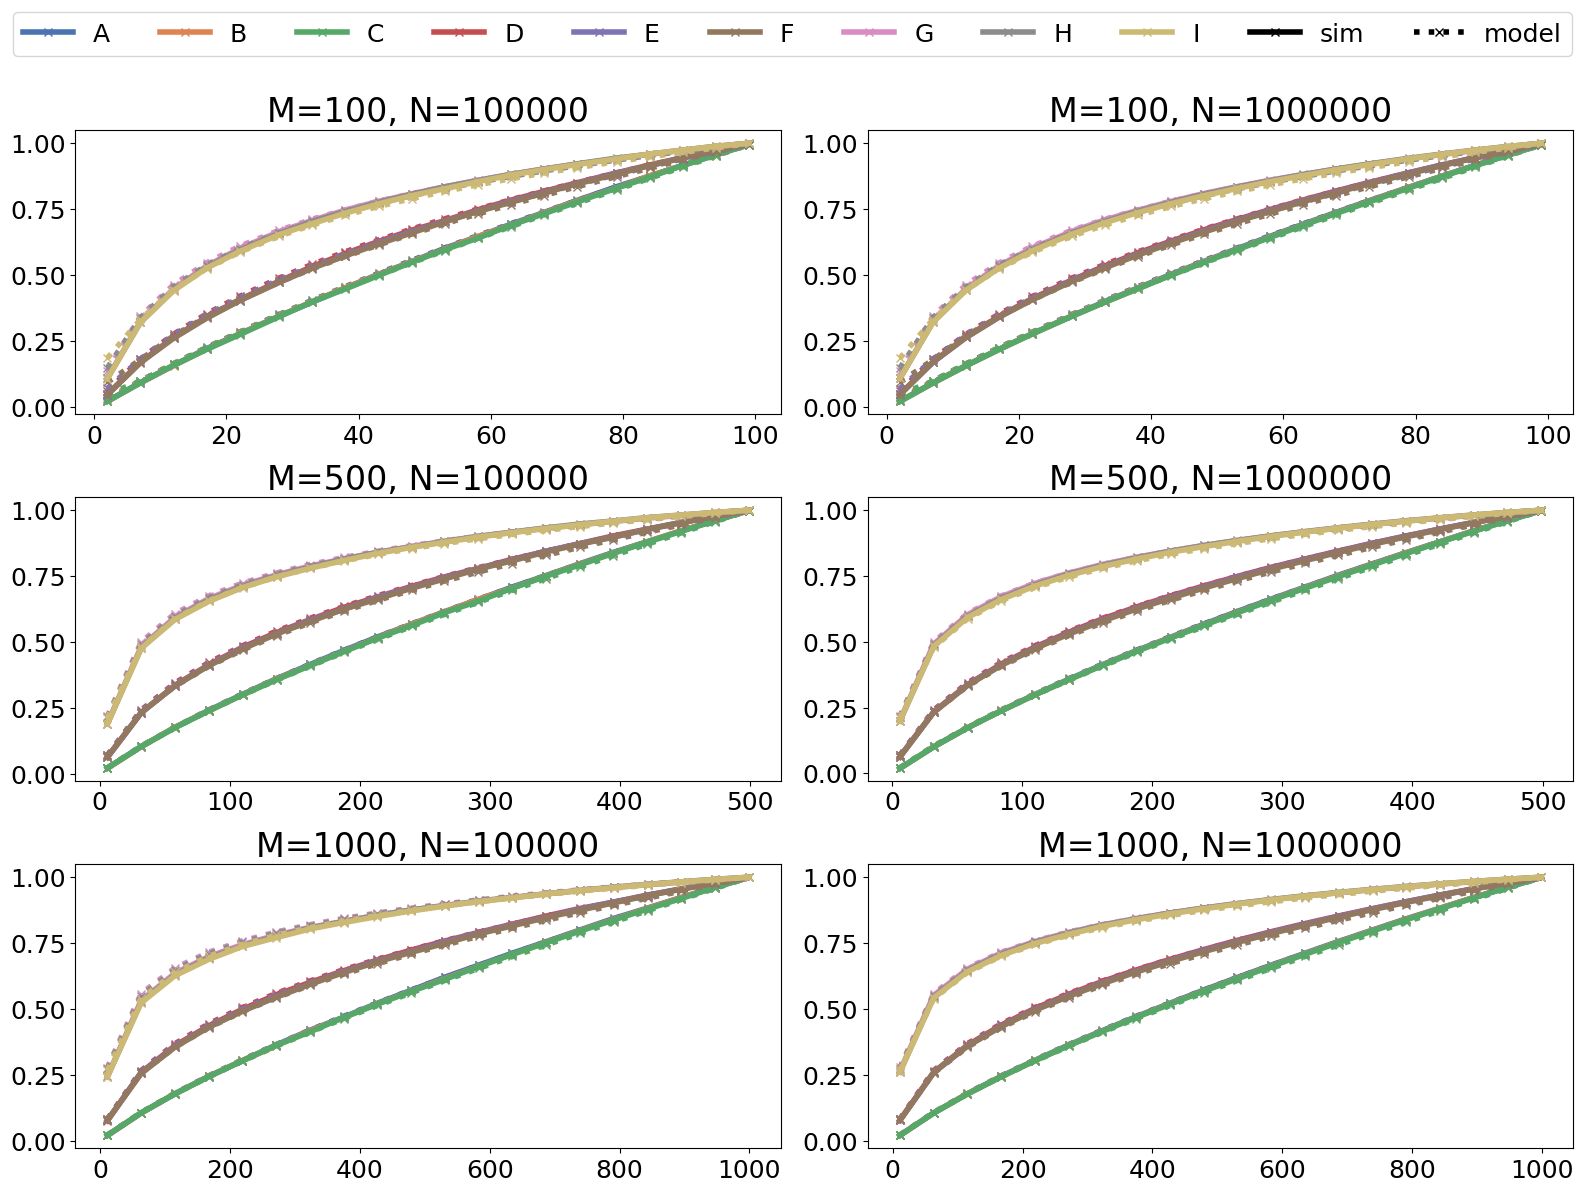

In [17]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

alphas = sorted(df_mr["alpha"].unique())
ks = sorted(df_mr["K"].unique())

labels = ['A','B','C','D','E','F','G','H','I']
pairs = list(itertools.product(alphas, ks))  # (alpha, K) → label
label_map = {pk: lab for pk, lab in zip(pairs, labels)}

rows = []
for r in df_mr.itertuples():
    lab = label_map[(r.alpha, r.K)]
    rows.append({
        "m": r.m, "n": r.n, "C": r.C,
        "label": lab, "type": "sim",
        "phit": 1.0 - r.mr_he_sim
    })
    rows.append({
        "m": r.m, "n": r.n, "C": r.C,
        "label": lab, "type": "model",
        "phit": 1.0 - r.mr_he_model
    })
df_plot = pd.DataFrame(rows)

sns.set_palette("deep")
font_axes = 24
font_ticks = 18
line_width = 4
palette = sns.color_palette("deep", len(labels))
color_map = dict(zip(labels, palette))

fig, axes = plt.subplots(len(ms), len(ns), figsize=(16, 12), sharex=False, sharey=False)

for i, m in enumerate(ms):
    for j, n in enumerate(ns):
        ax = axes[i, j]
        subset = df_plot[(df_plot.m == m) & (df_plot.n == n)]
        for label in labels:
            data = subset[subset.label == label]
            if data.empty:
                continue
            sim = data[data.type == 'sim'].sort_values('C')
            model = data[data.type == 'model'].sort_values('C')
            ax.plot(
                sim.C, sim.phit,
                marker='x', linestyle='-', linewidth=line_width,
                color=color_map[label]
            )
            ax.plot(
                model.C, model.phit,
                marker='x', linestyle=':', linewidth=line_width,
                color=color_map[label]
            )
        ax.set_title(f"M={m}, N={n}", fontsize=font_axes)
        ax.tick_params(labelsize=font_ticks)

handle_color = [
    Line2D([], [], color=color_map[label], marker='x', linestyle='-', linewidth=line_width, label=label)
    for label in labels
]
handle_type = [
    Line2D([], [], color='black', marker='x', linestyle='-', linewidth=line_width, label='sim'),
    Line2D([], [], color='black', marker='x', linestyle=':', linewidth=line_width, label='model')
]
handles = handle_color + handle_type
legend_labels = labels + ['sim', 'model']

fig.legend(handles, legend_labels, loc='upper center', ncol=len(labels)+2, fontsize=font_ticks)
fig.tight_layout(rect=[0, 0, 1, 0.93])

/tmp/ipykernel_1582799/1662380305.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks)
/tmp/ipykernel_1582799/1662380305.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks)
/tmp/ipykernel_1582799/1662380305.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks)
/tmp/ipykernel_1582799/1662380305.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(order, fontsize=font_ticks)
/tmp/ipykernel_1582799/1662380305.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e

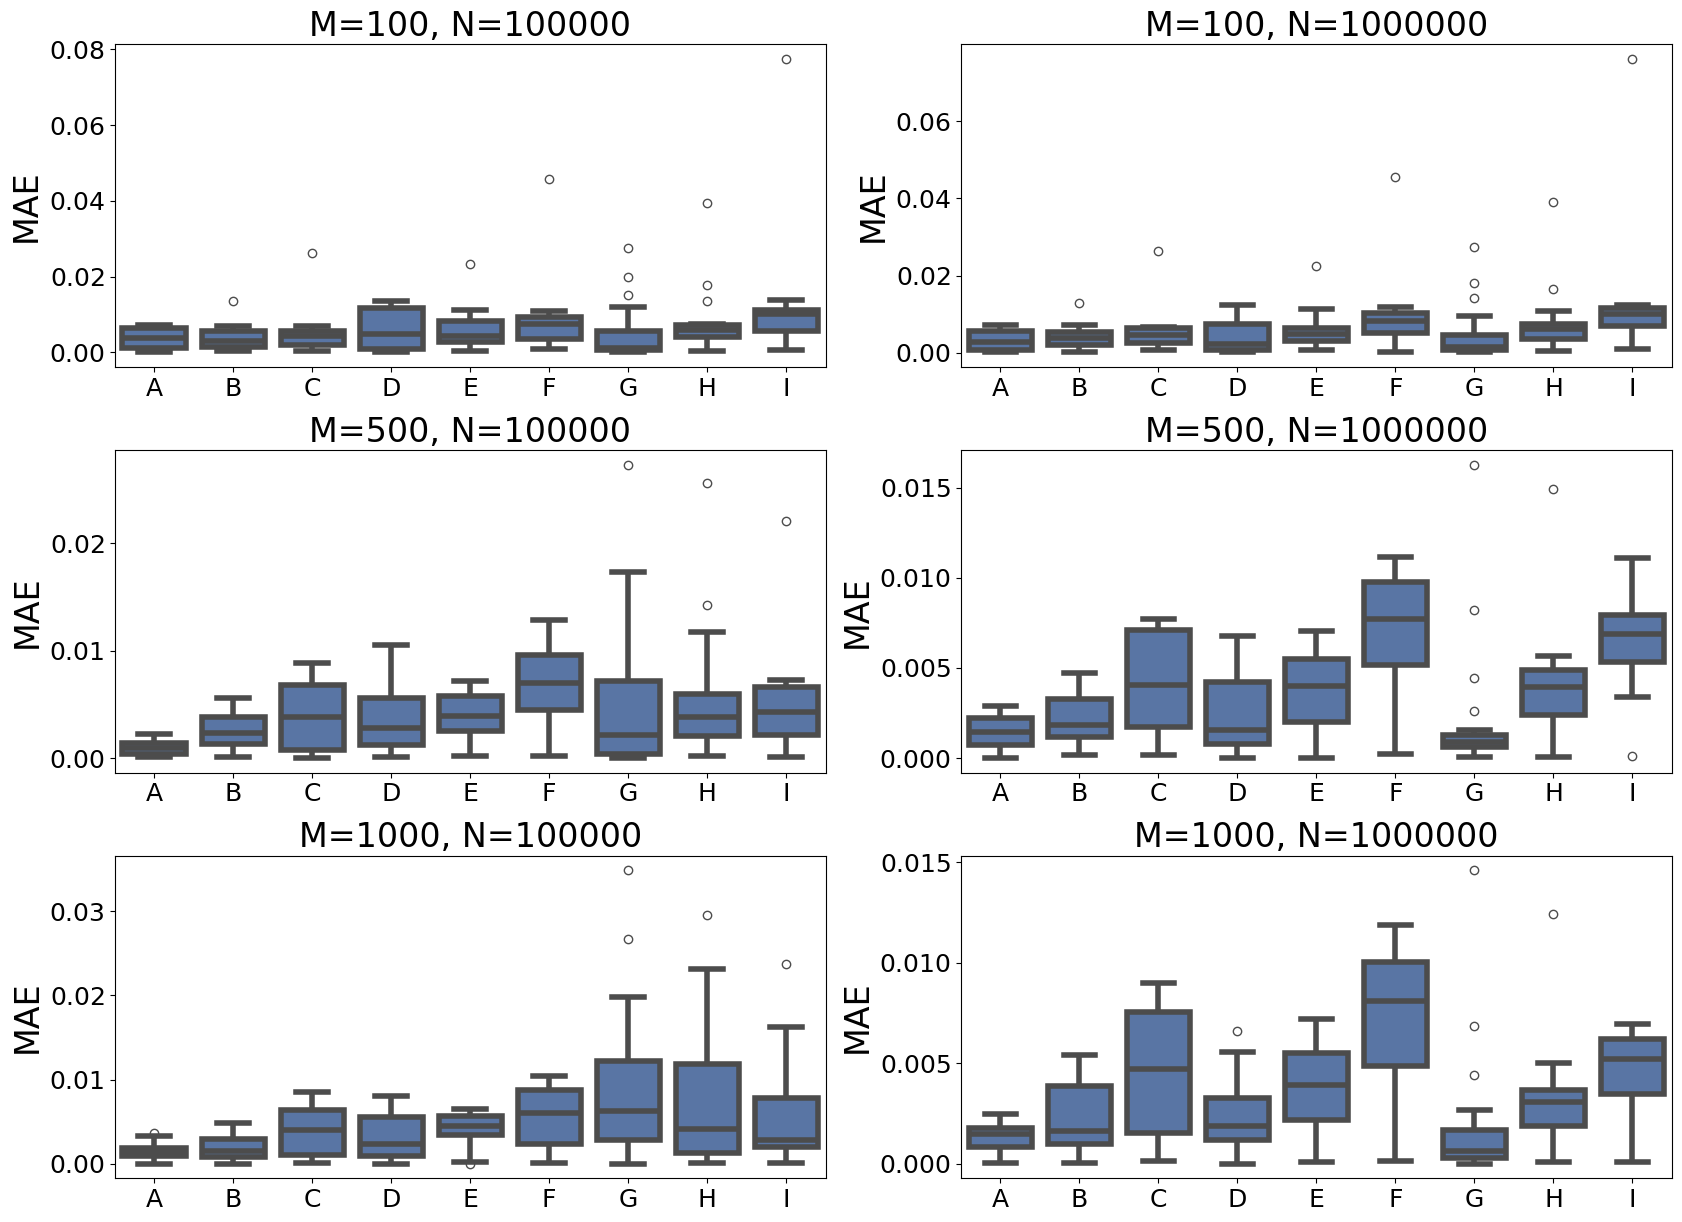

In [19]:
alphas = sorted(df_err["alpha"].unique())
ks = sorted(df_err["K"].unique())
labels = ['A','B','C','D','E','F','G','H','I']
pairs = list(itertools.product(alphas, ks))   # (alpha, K) → label
mapping = {pk: lab for pk, lab in zip(pairs, labels)}
order = sorted(mapping.values())

rows = []
for r in df_err.itertuples():
    rows.append({
        "m": r.m,
        "n": r.n,
        "C": r.C,
        "error": r.error_he,
        "method_param": (r.alpha, r.K)
    })
df_err_he = pd.DataFrame(rows)

M_list = ms
n_list = ns

fig2, axes2 = plt.subplots(len(M_list), len(n_list), figsize=(18, 14),
                           sharex=False, sharey=False)

for i, M in enumerate(M_list):
    for j, n in enumerate(n_list):
        ax2 = axes2[i, j]
        cell = df_err_he[(df_err_he.m == M) & (df_err_he.n == n)].copy()
        cell['short'] = cell['method_param'].map(mapping)
        sns.boxplot(x='short', y='error', data=cell, ax=ax2,
                    linewidth=line_width, order=order)
        ax2.set_title(f"M={M}, N={n}", fontsize=font_axes)
        ax2.tick_params(labelsize=font_ticks)
        ax2.set_xlabel('')
        ax2.set_ylabel("MAE", fontsize=font_axes)
        ax2.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax2.set_xticklabels(order, fontsize=font_ticks)

plt.tight_layout(rect=[0.03, 0.05, 0.97, 0.93])

In [21]:
alphas = sorted(df_err["alpha"].unique())
ks = sorted(df_err["K"].unique())
labels = ['A','B','C','D','E','F','G','H','I']
pairs = list(itertools.product(alphas, ks))
label_map = {pk: lab for pk, lab in zip(pairs, labels)}  # (alpha,K) -> label
inv_map = {lab: pk for pk, lab in label_map.items()}  # label -> (alpha,K)

rows = []
for lab in labels:
    a, K = inv_map[lab]
    rows.append(f"    {lab} & {a:.1f} & {K} \\\\")

latex = r"""\begin{table}[h]
  \centering
  \caption{Mapping between label identifiers and parameter combinations $(\alpha, K)$.}
  \label{tab:label_mapping}
  \begin{tabular}{lcc}
    \toprule
    Label & Zipf exponent $\alpha$ & $K$ \\
    \midrule
"""
for r in rows:
    latex += r + "\n"
latex += r"""    \bottomrule
  \end{tabular}
\end{table}"""

print(latex)

\begin{table}[h]
  \centering
  \caption{Mapping between label identifiers and parameter combinations $(\alpha, K)$.}
  \label{tab:label_mapping}
  \begin{tabular}{lcc}
    \toprule
    Label & Zipf exponent $\alpha$ & $K$ \\
    \midrule
    A & 0.5 & 1 \\
    B & 0.5 & 3 \\
    C & 0.5 & 5 \\
    D & 0.8 & 1 \\
    E & 0.8 & 3 \\
    F & 0.8 & 5 \\
    G & 1.1 & 1 \\
    H & 1.1 & 3 \\
    I & 1.1 & 5 \\
    \bottomrule
  \end{tabular}
\end{table}
